In [1]:
import warnings
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
from numba import cuda

import tensorflow as tf
from tensorflow import keras
from keras import layers

MAX_EPISODE = 200
MAX_STEP_PER_EPISODE = 500
GAMMA = 0.99
EPS = 1e-8

warnings.filterwarnings("ignore", category=DeprecationWarning)

2023-12-06 18:30:25.942262: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 18:30:26.694147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_actor_critic_model(input_shape, actor_out_shape, hidden_size):
    inputs = layers.Input(shape=input_shape)
    hidden = layers.Dense(hidden_size, activation='relu')(inputs)
    actor = layers.Dense(actor_out_shape, activation='softmax', name='actor')(hidden)
    critic = layers.Dense(1, activation='linear', name='critic')(hidden)

    return keras.Model(inputs=inputs, outputs=[actor,critic])

In [3]:
# env = gym.make("CartPole-v1") 
env = gym.make("LunarLander-v2")
states_shape = env.observation_space.shape[0]
n_actions = env.action_space.n

actor_critic = get_actor_critic_model(input_shape=states_shape,
                                     actor_out_shape=n_actions,
                                     hidden_size=32
)

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.01)
critic_loss_fn = keras.losses.Huber()

action_log_probs = []
critic_values = []
rewards = []
episode_rewards = []
running_rewards = []
running_reward = 0

for episode in range(1, MAX_EPISODE+1):
    state, _ = env.reset()
    episode_reward = 0
    
    with tf.GradientTape() as tape:
        # Collect trajectory
        for t in range(1, MAX_STEP_PER_EPISODE+1):
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)
            
            actions_prob, critic_val = actor_critic(state)
            critic_values.append(critic_val[0,0])
            
            action = np.random.choice(n_actions, p=np.squeeze(actions_prob))
            action_log_probs.append(tf.math.log(actions_prob[0, action]))
            
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            episode_reward += reward
            
            if done:
                break

        G = 0
        returns = deque(maxlen=len(rewards))
        for r in rewards[::-1]:
            G = r + GAMMA * G
            returns.appendleft(G)

        returns = np.array(returns)
        returns = (returns - returns.mean()) / (returns.std() + EPS)

        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in  zip(action_log_probs, critic_values, returns):
            advantage = ret - value
            actor_losses.append(-log_prob * advantage)
            critic_losses.append(
                critic_loss_fn(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )
            
         # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, actor_critic.trainable_variables)
        optimizer.apply_gradients(zip(grads, actor_critic.trainable_variables))

    # Clear the loss and reward history
    action_log_probs.clear()
    critic_values.clear()
    rewards.clear()

    episode_rewards.append(episode_reward)
    running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
    running_rewards.append(running_reward)

    if episode % 1 == 0:
        print(f"Episode {episode}:\tavg_episode_reward={np.mean(episode_rewards):.1f}\trunning_reward={running_reward:.1f}")
    if running_reward > 200: #termination condition
        print(f"Solved at {episode} episode: trunning_reward={running_reward}!")
        break
    if episode % 1000 == 0:
        clear_output()

# actor_critic.save_weights("checkpoints/ac_lunarlander.h5")

2023-12-06 18:30:28.197044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9831 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


Episode 1:	avg_episode_reward=-81.1	running_reward=-4.1
Episode 2:	avg_episode_reward=-156.9	running_reward=-15.5
Episode 3:	avg_episode_reward=-127.3	running_reward=-18.1
Episode 4:	avg_episode_reward=-118.4	running_reward=-21.8
Episode 5:	avg_episode_reward=-121.9	running_reward=-27.5
Episode 6:	avg_episode_reward=-101.3	running_reward=-26.0
Episode 7:	avg_episode_reward=-93.2	running_reward=-27.0
Episode 8:	avg_episode_reward=-80.6	running_reward=-25.3
Episode 9:	avg_episode_reward=-82.7	running_reward=-28.9
Episode 10:	avg_episode_reward=-86.2	running_reward=-33.4
Episode 11:	avg_episode_reward=-92.3	running_reward=-39.4
Episode 12:	avg_episode_reward=-95.6	running_reward=-44.0
Episode 13:	avg_episode_reward=-96.6	running_reward=-47.2
Episode 14:	avg_episode_reward=-109.1	running_reward=-58.5
Episode 15:	avg_episode_reward=-110.7	running_reward=-62.2
Episode 16:	avg_episode_reward=-109.3	running_reward=-63.5
Episode 17:	avg_episode_reward=-110.4	running_reward=-66.7
Episode 18:	avg

KeyboardInterrupt: 

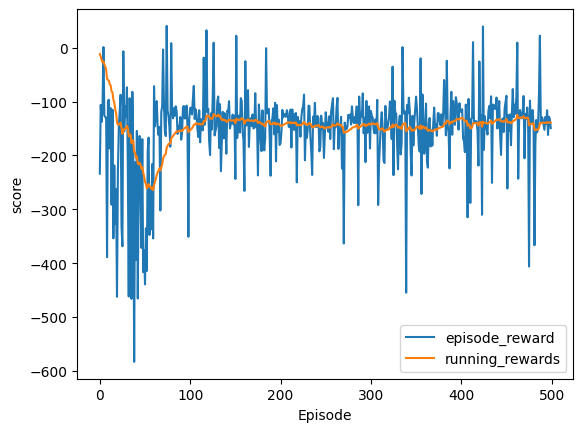

In [ ]:
plt.plot(episode_rewards, label='episode_reward')
plt.plot(running_rewards, label='running_rewards')
plt.ylabel('score')
plt.xlabel('Episode')
plt.legend()
plt.show()